# Inspired by Quantum tree generator improves QAOA state-of-the-art for the knapsack problem  Paul Christiansen et al. 2024

In [24]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from __future__ import annotations
from typing import List
import math
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import IntegerComparator
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.circuit.library import WeightedAdder, WeightedSumGate
from qiskit.quantum_info import DensityMatrix, partial_trace, Statevector

In [25]:
from collections import defaultdict

def build_qkp_cost_hamiltonian_without_constraint(n_items, profits):
    """
    Build the Hamiltonian qubo to the QKP just including the profits.
    Returns a sparsepauliop to use in qaoa.
    """

    pauli_dict = defaultdict(float)

    # Términos cuadráticos
    for i in range(n_items):
        for j in range(i, n_items):
            pauli_i = ["I"] * n_items
            pauli_i[i] = "Z"
            coeff = - 1/4 * profits[i][j]
            if i == j: 
                pauli_str = "".join(pauli_i)[::-1]
                pauli_dict[pauli_str] = coeff 
            else:
                pauli_j = pauli_i.copy()
                pauli_j[j] = "Z"
                pauli_str = "".join(pauli_j)[::-1]
                pauli_dict[pauli_str] += coeff * 2
        

    # Términos lineales
    for i in range(n_items):
        pauli_i = ["I"] * n_items
        pauli_i[i] = "Z"
        pauli_str = "".join(pauli_i)[::-1] 
        coeff = 0
        for j in range(0, n_items):
            coeff += 1/2 * profits[i][j]
        pauli_dict[pauli_str] += coeff

  
    return SparsePauliOp.from_list([(p, coeff) for p, coeff in pauli_dict.items() if abs(coeff) > 1e-8])

In [26]:
def _pad_with_identity(op: SparsePauliOp, n_total: int) -> SparsePauliOp:
    """Devuelve  op ⊗ I_(ancillas)  para igualar qubit‑count con el circuito."""
    n_sys = op.num_qubits
    ancillas = n_total - n_sys
    if ancillas == 0:
        return op
    # Identidad sobre 'ancillas' qubits (últimos, porque se añadieron después)
    id_anc = SparsePauliOp.from_list([("I" * ancillas, 1)])
    return id_anc.tensor(op)  #  H  ⊗  I_anc


In [27]:
n_items = 4
weights = [1, 1, 1, 1]
profits = np.array([[1, 1, 5, 1],
                    [1, 7, 3, 0],
                    [5, 3, 7, 4],
                    [1, 0, 4, 1]]
                    )
capacity = 3
real_solution = np.array([1, 1, 1, 0])

In [28]:
cost_hamiltonian = build_qkp_cost_hamiltonian_without_constraint(n_items, profits)
print("Hamiltonian QUBO:", cost_hamiltonian)

Hamiltonian QUBO: SparsePauliOp(['IIIZ', 'IIZZ', 'IZIZ', 'ZIIZ', 'IIZI', 'IZZI', 'IZII', 'ZZII', 'ZIII'],
              coeffs=[ 3.75+0.j, -0.5 +0.j, -2.5 +0.j, -0.5 +0.j,  3.75+0.j, -1.5 +0.j,
  7.75+0.j, -2.  +0.j,  2.75+0.j])


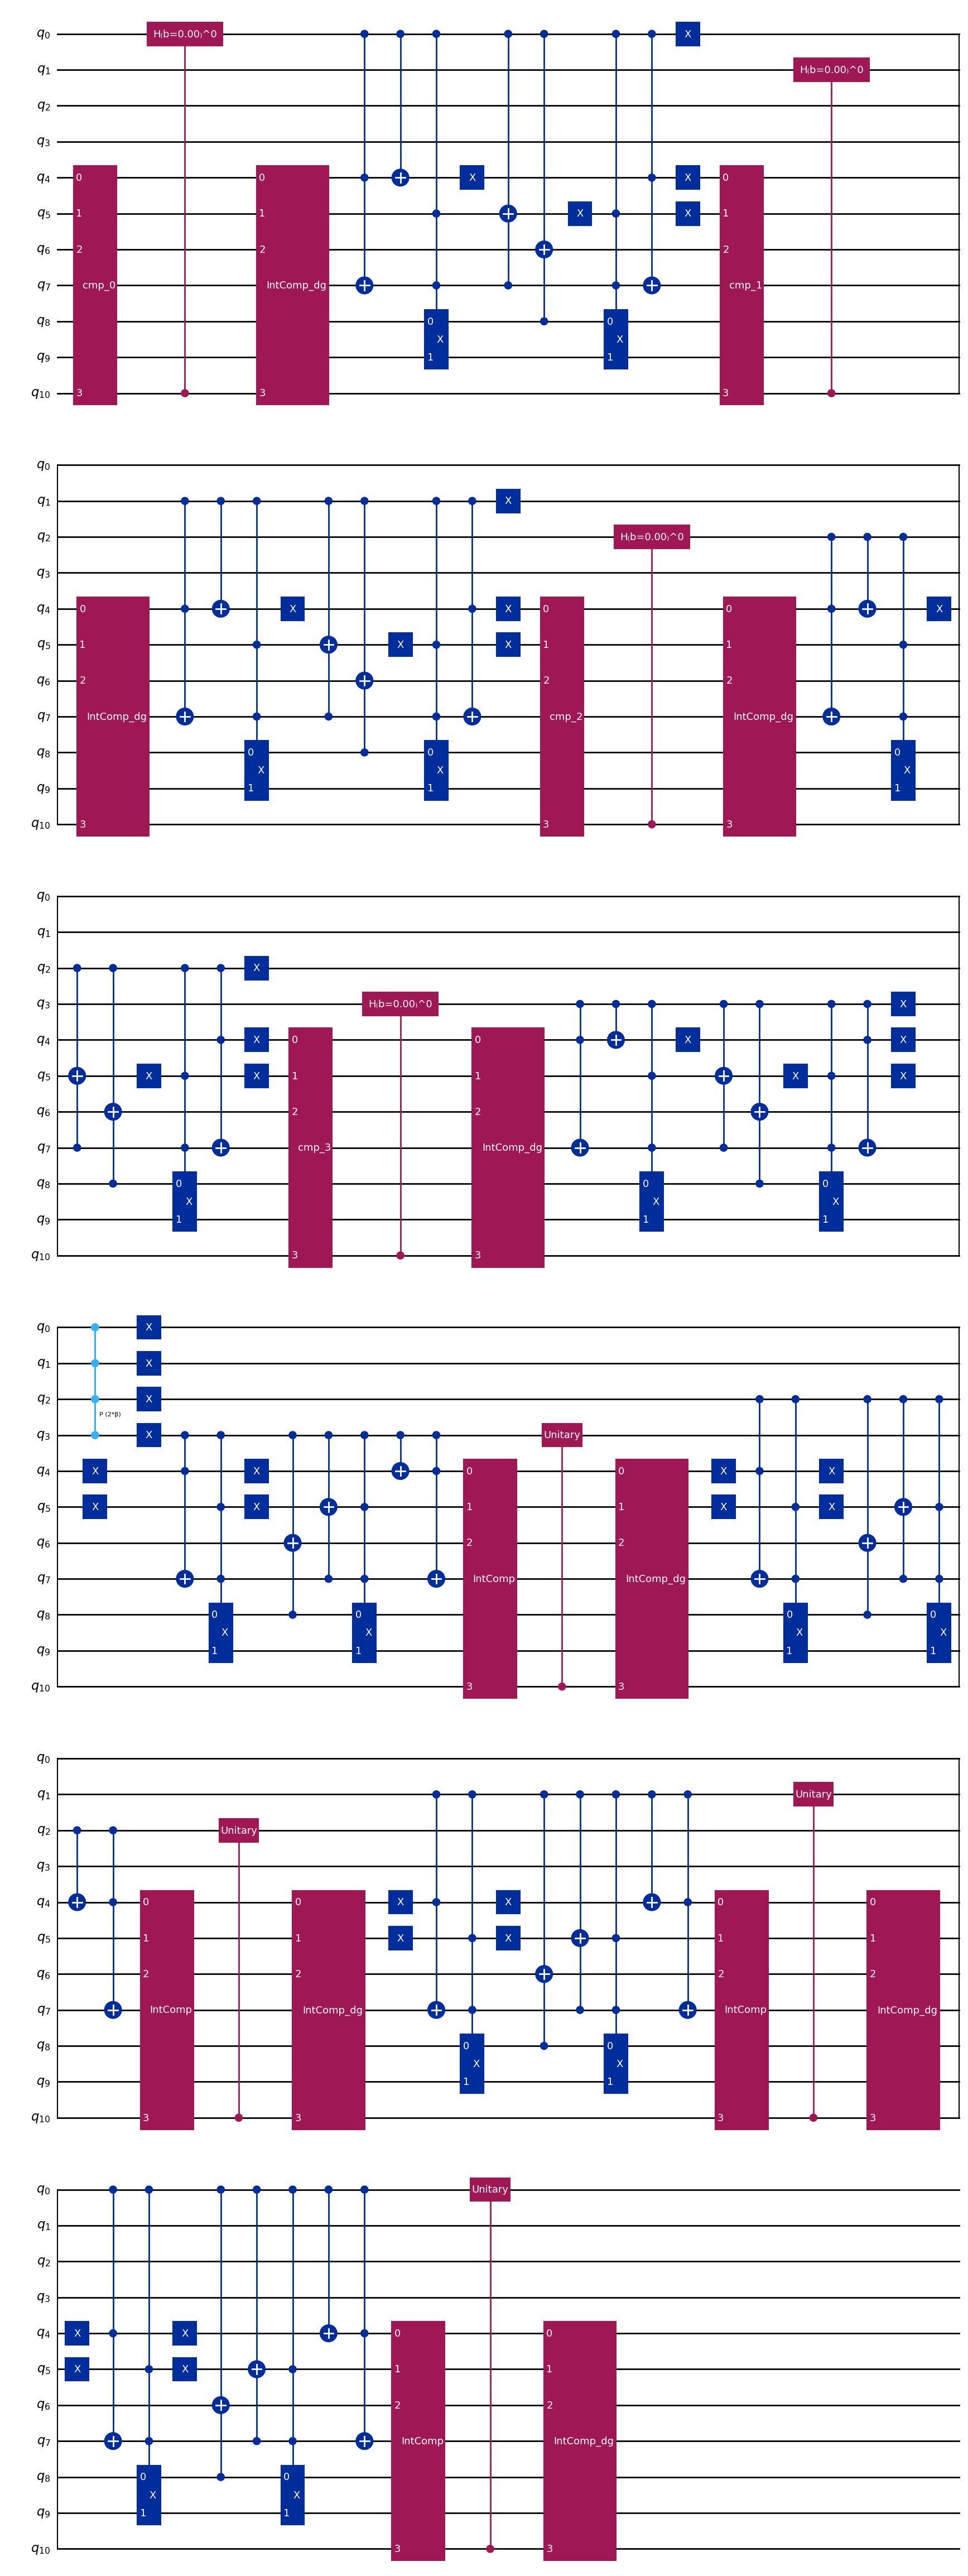

In [29]:
from qtg_mixer import build_qtg_mixer

mixer_qtg = build_qtg_mixer(n_items, weights=weights, capacity=capacity)
mixer_qtg.draw('mpl')


In [ ]:
from qtg import QTG

circuit = QuantumCircuit(n_items)  

circuit = QTG(
        num_state_qubits=n_items,  
        weights=weights,
        y_ansatz=[0] * n_items,  
        capacity=capacity)

circuit_vector = Statevector(circuit)
circuit_vector.draw(output='hinton')
print("Initial state vector:", circuit_vector)
# reg = ClassicalRegister(n_items, 'reg')
# circuit.add_register(reg)
# circuit.measure(circuit.qubits[0:n_items], reg)
circuit.draw('mpl')

In [31]:
# # Transpilar para el simulador
# simulator = Aer.get_backend('aer_simulator')
# transpiled_circuit = transpile(circuit, simulator)

# # Ejecutar el circuito
# shots = 10_000
# job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
# result = job.result()

# # Obtener conteos
# counts = result.get_counts()
# # Normalizar los resultados
# final_distribution = {key: val/shots for key, val in counts.items()}

# print(final_distribution)
# plot_histogram(counts)

In [32]:
cost_hamiltonian_ext = _pad_with_identity(cost_hamiltonian, circuit.num_qubits)
print("Hamiltonian QUBO con ancillas:", cost_hamiltonian_ext)

#circuit.remove_final_measurements() # Limpia las mediciones finales

# Crear el operador de mezcla como Operator (no QuantumCircuit)

# Creamos el operador de mezcla: RX(pi/2) en los primeros n_items qubits, identidad en el resto
num_qubits = circuit.num_qubits
mixer_terms = [
    ("I" * (num_qubits - i - 1) + "X" + "I" * i, 1) for i in range(n_items)
]
mixer_operator = SparsePauliOp.from_list(mixer_terms)

print("Mixer operator:", mixer_operator)

reps = 5
qaoa1 = QAOAAnsatz(
    cost_operator=cost_hamiltonian_ext, 
    reps=reps,
    initial_state=circuit,
    mixer_operator=mixer_qtg, 
    name="QAOA_Knapsack"
)

# alo = qaoa1.decompose().decompose()
# alo.draw('mpl')

Hamiltonian QUBO con ancillas: SparsePauliOp(['IIIIIIIIIIZ', 'IIIIIIIIIZZ', 'IIIIIIIIZIZ', 'IIIIIIIZIIZ', 'IIIIIIIIIZI', 'IIIIIIIIZZI', 'IIIIIIIIZII', 'IIIIIIIZZII', 'IIIIIIIZIII'],
              coeffs=[ 3.75+0.j, -0.5 +0.j, -2.5 +0.j, -0.5 +0.j,  3.75+0.j, -1.5 +0.j,
  7.75+0.j, -2.  +0.j,  2.75+0.j])
Mixer operator: SparsePauliOp(['IIIIIIIIIIX', 'IIIIIIIIIXI', 'IIIIIIIIXII', 'IIIIIIIXIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [33]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps
print("Parameters:", qaoa1.parameters)
print("Initial params:", init_params)


Parameters: ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4])])
Initial params: [3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966]


In [34]:
objective_func_vals = []

estimator = AerEstimator()
estimator.set_options(shots=1)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    circuit_bound = ansatz.assign_parameters(params, inplace=False)
    job = estimator.run([circuit_bound], [hamiltonian])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

result = minimize(
    cost_func_estimator,
    init_params,
    args=(qaoa1, cost_hamiltonian_ext, estimator),
    method="COBYLA", 
    tol=1e-10,
    options={'maxiter': 5000}
)

print("Optimization Result:\n", result)

AttributeError: 'Gate' object has no attribute 'value'

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
optimized_circuit = qaoa1.assign_parameters(result.x)
reg = ClassicalRegister(n_items, 'reg')
optimized_circuit.add_register(reg)
optimized_circuit.measure(qaoa1.qubits[0:n_items], reg)
optimized_circuit.draw('mpl')

In [ ]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Transpilar para el simulador
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(optimized_circuit, simulator)

# Ejecutar el circuito
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

# Obtener conteos
counts = result.get_counts()

# Normalizar los resultados
final_distribution = {key: val/shots for key, val in counts.items()}

print(final_distribution)
plot_histogram(counts)

In [ ]:
keys = list(final_distribution.keys())
values = list(final_distribution.values())
most_likely = keys[np.argmax(np.abs(values))]

result_bitstring = [int(digit) for digit in most_likely]
print("Result bitstring as list:", result_bitstring)

print(f"Real solution: ", real_solution)


# Using the improve function

In [ ]:
from QTG import QTG
   
circuit = QuantumCircuit(n_items)  

circuit = QTG(
        num_state_qubits=n_items,  
        weights=weights,
        y_ansatz=[0] * n_items,  
        capacity=capacity)

# reg = ClassicalRegister(n_items, 'reg')
# circuit.add_register(reg)
# circuit.measure(circuit.qubits[0:n_items], reg)
circuit.draw('mpl')

In [ ]:
from QAOA import SubsystemQAOAAnsatz

#circuit.remove_final_measurements() # Limpia las mediciones finales
reps = 20

qaoa2 = SubsystemQAOAAnsatz(cost_operator=cost_hamiltonian,
    reps=reps,
    initial_state=circuit,
    mixer_operator=None  # No mixer operator needed for this example
)

# alo = qaoa2.decompose().decompose()
# alo.draw('mpl')

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps
print("Parameters:", qaoa2.parameters)
print("Initial params:", init_params)

In [ ]:
objective_func_vals = []

estimator = AerEstimator()
estimator.set_options(shots=1)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    circuit_bound = ansatz.assign_parameters(params)
    job = estimator.run([circuit_bound], [hamiltonian])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

result = minimize(
    cost_func_estimator,
    init_params,
    args=(qaoa2, cost_hamiltonian_ext, estimator),
    method="COBYLA", 
    tol=1e-10,
    options={'maxiter': 5000}
)

print("Optimization Result:\n", result)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
optimized_circuit = qaoa2.assign_parameters(result.x)
reg = ClassicalRegister(n_items, 'reg')
optimized_circuit.add_register(reg)
optimized_circuit.measure(qaoa2.qubits[0:n_items], reg)
optimized_circuit.draw('mpl')

In [ ]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Transpilar para el simulador
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(optimized_circuit, simulator)

# Ejecutar el circuito
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

# Obtener conteos
counts = result.get_counts()

# Normalizar los resultados
final_distribution = {key: val/shots for key, val in counts.items()}

print(final_distribution)
plot_histogram(counts)

In [ ]:
keys = list(final_distribution.keys())
values = list(final_distribution.values())
most_likely = keys[np.argmax(np.abs(values))]

result_bitstring = [int(digit) for digit in most_likely]
print("Result bitstring as list:", result_bitstring)

print(f"Real solution: ", real_solution)
